# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [131]:
import os
import numpy as np
from pydub import AudioSegment
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import regularizers
import matplotlib.pyplot as plt
from python_speech_features import mfcc

In [132]:
# === 1. Параметри ===
DATASET_PATH = "./dataset/genres_original"  # Шлях до папки з аудіофайлами
SAMPLE_RATE = 22050  # Частота дискретизації
DURATION = 30  # Тривалість аудіо в секундах
MFCC_FEATURES = 40  # Кількість MFCC коефіцієнтів

In [133]:
# === 2. Функція для витягування фіч ===
# === Аугментація аудіо ===
def augment_audio(audio):
    try:
        # Додавання шуму
        noise = np.random.normal(0, 0.005, len(audio))
        audio_with_noise = audio + noise

        # Зміна гучності
        gain = np.random.uniform(0.9, 1.1)  # Від 90% до 110% початкової гучності
        audio_with_gain = audio * gain

        # Аугментований набір
        augmented_data = [audio, audio_with_noise, audio_with_gain]
        return augmented_data
    except Exception as e:
        print(f"Помилка при аугментації: {e}")
        return [audio]

def extract_features(file_path, max_duration=30, sample_rate=22050, mfcc_features=40):
    try:
        # Завантаження аудіофайлу
        audio = AudioSegment.from_file(file_path)
        audio = audio.set_frame_rate(sample_rate).set_channels(1)

        # Конвертуємо в масив NumPy
        audio_data = np.array(audio.get_array_of_samples(), dtype=np.float32) / (2 ** 15)

        # Обрізаємо або додаємо нулі
        max_samples = int(sample_rate * max_duration)
        if len(audio_data) > max_samples:
            audio_data = audio_data[:max_samples]
        else:
            pad_length = max_samples - len(audio_data)
            audio_data = np.pad(audio_data, (0, pad_length), mode='constant')

        # Аугментація
        augmented_audios = augment_audio(audio_data)
        print(f"Number of augmented versions for {file_path}: {len(augmented_audios)}")

        # Розрахунок MFCC для всіх аугментованих варіантів
        features = []
        for idx, audio in enumerate(augmented_audios):
            mfcc_features_result = mfcc(audio, samplerate=sample_rate, numcep=mfcc_features, nfft=1024)

            # Перевірка форми отриманих MFCC
            if mfcc_features_result.ndim == 2:  # Переконатися, що це 2D масив
                print(f"MFCC shape for augmented version {idx}: {mfcc_features_result.shape}")
                features.append(mfcc_features_result)
            else:
                print(f"Помилка: непередбачена форма результату MFCC для {file_path} на версії {idx}")

        return features
    except Exception as e:
        print(f"Помилка обробки {file_path}: {e}")
        return []

In [134]:
# === 3. Завантаження та підготовка даних ===
def load_data(dataset_path, sample_rate=22050, mfcc_features=40):
    features, labels = [], []

    for genre in os.listdir(dataset_path):
        genre_path = os.path.join(dataset_path, genre)
        if os.path.isdir(genre_path):
            for file in os.listdir(genre_path):
                file_path = os.path.join(genre_path, file)
                data = extract_features(file_path, sample_rate=sample_rate, mfcc_features=mfcc_features)
                if data is not None:
                    # Перевіряємо кількість зразків після аугментації
                    print(f"Number of samples for {file_path}: {len(data)}")
                    features.extend(data)  # Додаємо всі аугментовані варіанти
                    labels.extend([genre] * len(data))  # Мітки для всіх варіантів

    print(f"Кількість використаних зразків: {len(features)}")
    return np.array(features), np.array(labels)

# Завантаження даних
print("Завантаження даних...")
features, labels = load_data(DATASET_PATH)

# Завантаження даних
print("Завантаження даних...")
features, labels = load_data(DATASET_PATH)

# Перевірка форми після завантаження всіх зразків
print(f"Форма features після завантаження: {features.shape}")
print(f"Форма labels після завантаження: {labels.shape}")

if len(features) == 0:
    raise ValueError("Немає валідних даних для навчання.")

# Перетворення міток у числовий формат
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Перевірка кількості класів
num_classes = len(np.unique(labels_encoded))
print(f"Кількість класів (жанрів): {num_classes}")

# Розбиваємо на тренувальний і тестовий набір
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Перетворення розмірності для CNN
X_train = X_train[..., np.newaxis]  # Додаємо канал
X_test = X_test[..., np.newaxis]

print(f"Розмір тренувального набору: {X_train.shape}")
print(f"Розмір тестового набору: {X_test.shape}")

Завантаження даних...
Number of augmented versions for ./dataset/genres_original\blues\blues.00000.wav: 3
MFCC shape for augmented version 0: (2992, 26)
MFCC shape for augmented version 1: (2992, 26)
MFCC shape for augmented version 2: (2992, 26)
Number of samples for ./dataset/genres_original\blues\blues.00000.wav: 3
Number of augmented versions for ./dataset/genres_original\blues\blues.00001.wav: 3
MFCC shape for augmented version 0: (2992, 26)
MFCC shape for augmented version 1: (2992, 26)
MFCC shape for augmented version 2: (2992, 26)
Number of samples for ./dataset/genres_original\blues\blues.00001.wav: 3
Number of augmented versions for ./dataset/genres_original\blues\blues.00002.wav: 3
MFCC shape for augmented version 0: (2992, 26)
MFCC shape for augmented version 1: (2992, 26)
MFCC shape for augmented version 2: (2992, 26)
Number of samples for ./dataset/genres_original\blues\blues.00002.wav: 3
Number of augmented versions for ./dataset/genres_original\blues\blues.00003.wav: 3


In [150]:
# === 4. Побудова моделі ===
def build_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),

        # Перший блок
        # tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),

        # Другий блок
        # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),

        # Третій блок
        # tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


# Визначення моделі
input_shape = (X_train.shape[1], X_train.shape[2], 1)
num_classes = len(np.unique(labels_encoded))
model = build_cnn_model(input_shape, num_classes)
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_98 (Conv2D)              │ (None, 2990, 24, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 2990, 24, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 1495, 12, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 1495, 12, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 1493, 10, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 1493, 10, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 746, 5, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 746, 5, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 744, 3, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 744, 3, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 372, 1, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 372, 1, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,050 (97.85 KB)

 Trainable params: 24,826 (96.98 KB)

 Non-trainable params: 224 (896.00 B)

Навчання моделі...
Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 847ms/step - accuracy: 0.2493 - loss: 2.1231 - val_accuracy: 0.2483 - val_loss: 2.1134
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 888ms/step - accuracy: 0.5262 - loss: 1.5277 - val_accuracy: 0.5917 - val_loss: 1.4907
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 899ms/step - accuracy: 0.6144 - loss: 1.2217 - val_accuracy: 0.4833 - val_loss: 1.5183
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 907ms/step - accuracy: 0.6988 - loss: 1.0177 - val_accuracy: 0.6683 - val_loss: 1.1240
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 65s 863ms/step - accuracy: 0.7247 - loss: 0.9299 - val_accuracy: 0.5267 - val_loss: 1.3619
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 857ms/step - accuracy: 0.7646 - loss: 0.8494 - val_accuracy: 0.7117 - val_loss: 0.9497
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 891ms/step - accuracy: 0.7715 - loss: 0.7823 - val_accuracy: 0.6850 - val_loss: 0.9673
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 912ms/step - accuracy: 0.7914 - loss

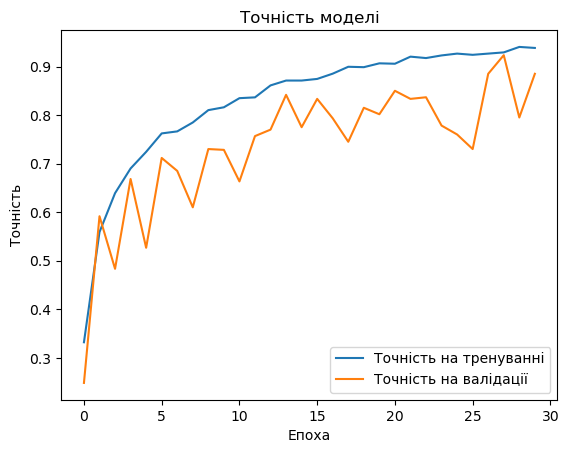

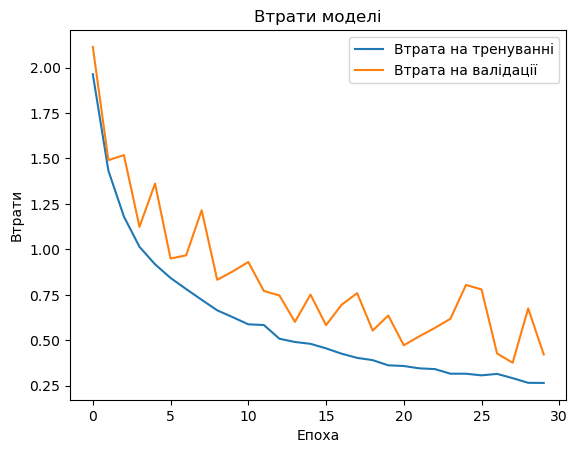

In [152]:
# === 5. Навчання моделі ===
def train_model(model, X_train, y_train, X_test, y_test, epochs=30, batch_size=32):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
    )
    return history


print("Навчання моделі...")
history = train_model(model, X_train, y_train, X_test, y_test, epochs=30, batch_size=32)

# Відображення графіків
plt.plot(history.history['accuracy'], label='Точність на тренуванні')
plt.plot(history.history['val_accuracy'], label='Точність на валідації')
plt.title('Точність моделі')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Втрата на тренуванні')
plt.plot(history.history['val_loss'], label='Втрата на валідації')
plt.title('Втрати моделі')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()
plt.show()


In [156]:
# === 6. Оцінка моделі ===
def evaluate_model(model, X_test, y_test):
    # Оцінка моделі на тестовому наборі
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Точність на тестових даних: {test_accuracy * 100:.2f}%")

    # Повертаємо точність як результат для подальшого використання
    return test_accuracy


# Оцінка моделі
evaluate_model(model, X_test, y_test)


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8838 - loss: 0.4314
Точність на тестових даних: 88.50%


0.8849999904632568

In [154]:
# === 7. Збереження моделі ===
def save_model(model, encoder, model_path="music_genre_model.keras", encoder_path="label_encoder.npy"):
    # Збереження моделі у форматі Keras
    model.save(model_path)
    # Збереження класів з енкодера (не сам енкодер, а тільки мітки)
    np.save(encoder_path, encoder.classes_)
    print(f"Модель збережено у {model_path}, енкодер у {encoder_path}")


# Збереження моделі та енкодера
save_model(model, label_encoder)

Модель збережено у music_genre_model.keras, енкодер у label_encoder.npy


In [157]:
# === 8. Завантаження моделі для прогнозування ===
# Функція для прогнозування жанру
def predict_genre(file_path, model_path="music_genre_model.keras", encoder_path="label_encoder.npy"):
    # Завантаження моделі
    model = tf.keras.models.load_model(model_path)

    # Завантаження класів для енкодера
    encoder_classes = np.load(encoder_path, allow_pickle=True)
    encoder = LabelEncoder()
    encoder.classes_ = encoder_classes  # Завантажуємо класи збереженого енкодера

    # Витягування ознак для прогнозування (з одного файлу)
    features_list = extract_features(file_path)
    if features_list:
        # Беремо перший екземпляр з усіх аугментованих варіантів
        features = features_list[0]
        features = np.expand_dims(features, axis=0)  # Додаємо вимір для пакетного оброблення
        features = features[..., np.newaxis]  # Додаємо канал (як у тренуванні)

        # Прогнозування жанру
        prediction = model.predict(features)
        genre = encoder.inverse_transform([np.argmax(prediction)])  # Перетворення індексу в жанр
        return genre[0]
    else:
        return "Не вдалося обробити файл."

print(predict_genre("./dataset/genres_original/blues/blues.00010.wav"))
print(predict_genre("./dataset/genres_original/classical/classical.00041.wav"))
print(predict_genre("./dataset/genres_original/country/country.00071.wav"))
print(predict_genre("./dataset/genres_original/disco/disco.00081.wav"))
print(predict_genre("./dataset/genres_original/hiphop/hiphop.00091.wav"))
print(predict_genre("./dataset/genres_original/jazz/jazz.00031.wav"))
print(predict_genre("./dataset/genres_original/metal/metal.00021.wav"))
print(predict_genre("./dataset/genres_original/pop/pop.00022.wav"))
print(predict_genre("./dataset/genres_original/reggae/reggae.00048.wav"))
print(predict_genre("./dataset/genres_original/rock/rock.00034.wav"))

Number of augmented versions for ./dataset/genres_original/blues/blues.00010.wav: 3
MFCC shape for augmented version 0: (2992, 26)
MFCC shape for augmented version 1: (2992, 26)
MFCC shape for augmented version 2: (2992, 26)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
blues
Number of augmented versions for ./dataset/genres_original/classical/classical.00041.wav: 3
MFCC shape for augmented version 0: (2992, 26)
MFCC shape for augmented version 1: (2992, 26)
MFCC shape for augmented version 2: (2992, 26)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
classical
Number of augmented versions for ./dataset/genres_original/country/country.00071.wav: 3
MFCC shape for augmented version 0: (2992, 26)
MFCC shape for augmented version 1: (2992, 26)
MFCC shape for augmented version 2: (2992, 26)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
country
Number of augmented versions for ./dataset/genres_original/disco/disco.00081.wav: 3
MFCC shape for augmented version 0: (2992, 26)
MFCC shape for augmented version 1: (2992, 